In [1]:
# Install required libraries
!pip install wfdb biosppy tensorflow shap numpy scipy pandas matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [2]:
import wfdb
import os

# Create a directory to store the data
os.makedirs('/content/ptbdb/patient001', exist_ok=True)

# Download the specific record files (s0010_re.dat, s0010_re.hea, s0010_re.xyz)
base_url = 'https://physionet.org/files/ptbdb/1.0.0/patient001/'
record_name = 's0010_re'
for ext in ['dat', 'hea', 'xyz']:
    print(f"Downloading {record_name}.{ext}...")
    result = os.system(f'wget --no-check-certificate -P /content/ptbdb/patient001/ {base_url}{record_name}.{ext}')
    if result != 0:
        print(f"Failed to download {record_name}.{ext}. Check your internet connection or URL.")

# Verify downloaded files
print("\nFiles in directory:")
!ls -l /content/ptbdb/patient001/

# Load the record using wfdb
record_path = '/content/ptbdb/patient001/s0010_re'
try:
    record = wfdb.rdsamp(record_path)
    signals = record[0]  # ECG signals (15 leads)
    fields = record[1]   # Metadata (e.g., sampling rate, lead names)

    # Print basic information
    print("\nRecord Name:", record_name)
    print("Number of Signals:", fields['n_sig'])
    print("Sampling Frequency:", fields['fs'])
    print("Signal Names:", fields['sig_name'])

    # Load and display the .xyz file (Frank leads)
    xyz_data = wfdb.rdrecord(record_path, channels=[12, 13, 14])  # vx, vy, vz
    print("\nFrank Leads (vx, vy, vz) Shape:", xyz_data.p_signal.shape)
except Exception as e:
    print(f"Error loading record: {e}")


Files in directory:
total 1132
-rw-r--r-- 1 root root 921600 Aug  3  2004 s0010_re.dat
-rw-r--r-- 1 root root   2687 Mar 22  2016 s0010_re.hea
-rw-r--r-- 1 root root 230400 Aug  3  2004 s0010_re.xyz

Record Name: s0010_re
Number of Signals: 15
Sampling Frequency: 1000
Signal Names: ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'vx', 'vy', 'vz']

Frank Leads (vx, vy, vz) Shape: (38400, 3)


In [4]:
# Install required libraries
!pip install peakutils

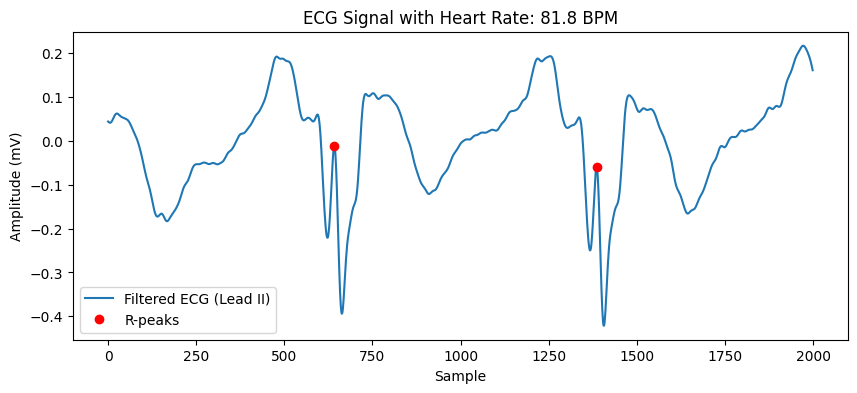

Number of R-peaks: 51
Mean Heart Rate: 81.79959100204499 BPM
Mean RR Interval: 0.7334999999999999 seconds


In [5]:
import numpy as np
from scipy.signal import butter, filtfilt
from biosppy.signals import ecg
import matplotlib.pyplot as plt

# Select Lead II (index 1 in signals from Step 2)
lead_ii = signals[:, 1]  # Lead II is the second column
fs = fields['fs']  # Sampling frequency (1000 Hz)

# Define bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply filter
b, a = butter_bandpass(0.5, 40, fs)
filtered_signal = filtfilt(b, a, lead_ii)

# Detect QRS complexes
ecg_out = ecg.ecg(signal=filtered_signal, sampling_rate=fs, show=False)
r_peaks = ecg_out['rpeaks']
rr_intervals = np.diff(r_peaks) / fs  # RR intervals in seconds

# Calculate heart rate (beats per minute)
heart_rate = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0

# Plot filtered signal and R-peaks
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal[:2000], label='Filtered ECG (Lead II)')  # First 2 seconds
plt.plot(r_peaks[r_peaks < 2000], filtered_signal[r_peaks[r_peaks < 2000]], 'ro', label='R-peaks')
plt.title(f'ECG Signal with Heart Rate: {heart_rate:.1f} BPM')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.show()

# Print extracted features
print("Number of R-peaks:", len(r_peaks))
print("Mean Heart Rate:", heart_rate, "BPM")
print("Mean RR Interval:", np.mean(rr_intervals) if len(rr_intervals) > 0 else 0, "seconds")

In [6]:
from scipy import signal
import pandas as pd
import numpy as np

# Initialize lists to store features
features = []

# Process all 15 leads
for lead_idx, lead_name in enumerate(fields['sig_name']):
    lead_signal = signals[:, lead_idx]

    # Filter signal
    filtered_signal = filtfilt(b, a, lead_signal)

    # QRS detection
    ecg_out = ecg.ecg(signal=filtered_signal, sampling_rate=fs, show=False)
    r_peaks = ecg_out['rpeaks']
    rr_intervals = np.diff(r_peaks) / fs

    # Time-domain features
    rr_mean = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    rr_std = np.std(rr_intervals) if len(rr_intervals) > 0 else 0

    # Frequency-domain features (LF/HF ratio)
    if len(rr_intervals) > 0:
        freqs, power = signal.welch(rr_intervals, fs=1/np.mean(rr_intervals), nperseg=min(len(rr_intervals), 256))
        lf_band = (0.04, 0.15)  # Low frequency
        hf_band = (0.15, 0.4)   # High frequency
        lf_power = np.sum(power[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])
        hf_power = np.sum(power[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])
        lf_hf_ratio = lf_power / hf_power if hf_power != 0 else 0
    else:
        lf_hf_ratio = 0

    # Store features
    features.append({
        'lead': lead_name,
        'rr_mean': rr_mean,
        'rr_std': rr_std,
        'lf_hf_ratio': lf_hf_ratio
    })

# Convert to DataFrame
features_df = pd.DataFrame(features)

# Vectorcardiography features from .xyz file
xyz_file = '/content/ptbdb/patient001/s0010_re.xyz'
try:
    xyz_data = np.loadtxt(xyz_file)  # Load vx, vy, vz
    vector_magnitude = np.sqrt(np.sum(xyz_data**2, axis=1))  # Compute 3D magnitude
    features_df['vector_magnitude_mean'] = np.mean(vector_magnitude)
except Exception as e:
    print(f"Error reading XYZ file: {e}")
    features_df['vector_magnitude_mean'] = 0

# Display features
print(features_df)

Error reading XYZ file: 'utf-8' codec can't decode byte 0xfd in position 0: invalid start byte
   lead  rr_mean    rr_std  lf_hf_ratio  vector_magnitude_mean
0     i  0.73352  0.009466     0.238341                      0
1    ii  0.73350  0.009150     0.275003                      0
2   iii  0.73352  0.009317     0.255537                      0
3   avr  0.73354  0.009466     0.272128                      0
4   avl  0.73350  0.009420     0.244411                      0
5   avf  0.73330  0.011697     0.129120                      0
6    v1  0.73352  0.009261     0.268827                      0
7    v2  0.73350  0.009235     0.245913                      0
8    v3  0.73350  0.009181     0.266550                      0
9    v4  0.73350  0.009129     0.264820                      0
10   v5  0.73350  0.009056     0.300902                      0
11   v6  0.73352  0.009172     0.276914                      0
12   vx  0.73352  0.009298     0.254796                      0
13   vy  0.73350  0.062

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Simulate data (replace with real data in practice)
X_ecg = np.random.randn(100, 1000, 15)  # 100 samples, 1000 time points, 15 leads
X_metadata = np.random.randn(100, 2)     # 100 samples, 2 metadata features (e.g., age, gender)
y = np.random.randint(0, 9, 100)         # 9 diagnostic classes
y = tf.keras.utils.to_categorical(y)     # One-hot encode labels

# Define multimodal model
def build_multimodal_model(ecg_shape, metadata_shape):
    # ECG branch (CNN)
    ecg_input = layers.Input(shape=ecg_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu')(ecg_input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=5, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)

    # Metadata branch
    metadata_input = layers.Input(shape=metadata_shape)
    y = layers.Dense(32, activation='relu')(metadata_input)

    # Combine branches
    combined = layers.Concatenate()([x, y])
    z = layers.Dense(64, activation='relu')(combined)
    output = layers.Dense(9, activation='softmax')(z)

    model = models.Model(inputs=[ecg_input, metadata_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train model
model = build_multimodal_model(ecg_shape=(1000, 15), metadata_shape=(2,))
model.fit([X_ecg, X_metadata], y, epochs=5, batch_size=32, validation_split=0.2)

# Print model summary
model.summary()

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.1375 - loss: 3.1347 - val_accuracy: 0.1500 - val_loss: 2.2038
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2008 - loss: 2.2490 - val_accuracy: 0.0500 - val_loss: 2.3298
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.2508 - loss: 2.0022 - val_accuracy: 0.0500 - val_loss: 2.4440
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.3500 - loss: 1.8879 - val_accuracy: 0.0000e+00 - val_loss: 2.4488
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4539 - loss: 1.7767 - val_accuracy: 0.0500 - val_loss: 2.3823


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 15)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 996, 64)   │      4,864 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 498, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 494, 128)  │     41,088 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         96 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │        585 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 170,813 (667.24 KB)

 Trainable params: 56,937 (222.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,876 (444.83 KB)

In [8]:
# Prepare data for autoencoder
X_train = filtered_signal[:1000].reshape(1, 1000, 1)  # First 1000 samples of Lead II

# Define autoencoder
def build_autoencoder(signal_shape):
    input_signal = layers.Input(shape=signal_shape)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_signal)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoded = layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)

    autoencoder = models.Model(input_signal, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train autoencoder
autoencoder = build_autoencoder(signal_shape=(1000, 1))
autoencoder.fit(X_train, X_train, epochs=10, batch_size=1)

# Detect anomalies
reconstructed = autoencoder.predict(X_train)
mse = np.mean(np.square(X_train - reconstructed), axis=(1, 2))
print("Reconstruction Error:", mse)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0078
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0073
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0068
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0064
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0059
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0055
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0050
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0045
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0040
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Reconstruction Error: [0.00293062]


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use HRV features from Step 4
X_hrv = features_df[['rr_mean', 'rr_std', 'lf_hf_ratio']].values
y_stress = np.random.randint(0, 2, len(X_hrv))  # 0: non-stressed, 1: stressed

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_hrv, y_stress, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Stress Detection Accuracy:", accuracy_score(y_test, y_pred))

Stress Detection Accuracy: 0.3333333333333333
